# Metric Learning Homework

Author: **Dmytro Lopushanskyy**

# Imports

In [1]:
import os
import yaml
import numpy as np
import pandas as pd
import json
import time
import random
import copy
import cv2
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import albumentations as albu
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
from annoy import AnnoyIndex
from pytorch_metric_learning import losses
from tqdm import tqdm

data_path = '/home/dmytro/metric-learning/Stanford_Online_Products/'
random.seed(5)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data

Unzip the archive into a local filesystem

In [2]:
# !unzip -q '/home/dmytro/metric-learning/Stanford_Online_Products.zip' -d '/home/dmytro/metric-learning/'

In [3]:
full_train_df = pd.read_csv(os.path.join(data_path, 'Ebay_train.txt'), sep=' ')
full_train_df.set_index('image_id')

,class_id,super_class_id,path
image_id,,,
1,1,1,bicycle_final/111085122871_0.JPG
2,1,1,bicycle_final/111085122871_1.JPG
3,1,1,bicycle_final/111085122871_2.JPG
4,1,1,bicycle_final/111085122871_3.JPG
5,1,1,bicycle_final/111085122871_4.JPG
...,...,...,...
59547,11318,12,toaster_final/221852410489_0.JPG
59548,11318,12,toaster_final/221852410489_1.JPG
59549,11318,12,toaster_final/221852410489_2.JPG


In [4]:
test_df = pd.read_csv(os.path.join(data_path, 'Ebay_test.txt'), sep=' ')
test_df.set_index('image_id')

,class_id,super_class_id,path
image_id,,,
59552,11319,1,bicycle_final/251952414262_0.JPG
59553,11319,1,bicycle_final/251952414262_1.JPG
59554,11319,1,bicycle_final/251952414262_2.JPG
59555,11319,1,bicycle_final/251952414262_3.JPG
59556,11319,1,bicycle_final/251952414262_4.JPG
...,...,...,...
120049,22633,12,toaster_final/400977584616_1.JPG
120050,22634,12,toaster_final/400977722713_0.JPG
120051,22634,12,toaster_final/400977722713_1.JPG


## Split the train dataset into train & validation

In [5]:
train_df, valid_df = train_test_split(
    full_train_df, 
    test_size=0.2, 
    random_state=42, 
    stratify=full_train_df[['class_id']]
)

In [6]:
train_df

,image_id,class_id,super_class_id,path
5237,5238,762,2,cabinet_final/131549715988_0.JPG
14875,14876,2484,3,chair_final/221591724921_2.JPG
18200,18201,3115,4,coffee_maker_final/151784132119_5.JPG
41995,41996,7527,9,sofa_final/111690092914_2.JPG
5994,5995,908,2,cabinet_final/151563594880_0.JPG
...,...,...,...,...
31606,31607,5546,7,lamp_final/151762188374_0.JPG
37152,37153,6585,8,mug_final/141740701326_1.JPG
56388,56389,10689,12,toaster_final/131575345407_4.JPG
35208,35209,6201,8,mug_final/111641075307_3.JPG


# Create custom dataset & dataloader

This class will help to keep different parts of code logic separate and follow PyTorch model training design.

### Important: this dataset class also performs data augmentation using albumentations library to prevent overfitting and generalize better.

In [7]:
class ProductsDataset(Dataset):    
    def __init__(self, df):
        # df should have these cols: class_id, super_class_id, path
        self.df = df
        self.img_size = (250, 250)
        
        self.augmenter = albu.Compose([
            albu.HorizontalFlip(),
            albu.ShiftScaleRotate(shift_limit=0.0, scale_limit=0.1, rotate_limit=10, p=0.4),
            albu.OneOf(
                [
                    albu.RandomBrightnessContrast(),
                    albu.RandomGamma(),
                    albu.MedianBlur(),
                ], 
                p=0.5
            ),
        ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        class_id = self.df.iloc[idx]['class_id']
        super_class_id = self.df.iloc[idx]['super_class_id']
        img_path = data_path + self.df.iloc[idx]['path']
        
        if type(img_path) == pd.Series:
            img_path = img_path.values[0]
        
        img = cv2.imread(f'{img_path}')
        img = cv2.resize(img, self.img_size, interpolation=cv2.INTER_NEAREST)
        
        img = self.augmenter(image=img)['image']
        img = img.transpose((2, 0, 1))  # HWC -> CHW
        
        return np.float32(img / 255), class_id, super_class_id

In [8]:
train_dataset = ProductsDataset(train_df)
valid_dataset = ProductsDataset(valid_df)
test_dataset = ProductsDataset(test_df)

In [9]:
def visualize_img(idx, verbose=False):
    img, class_id, super_class_id = train_dataset[idx]

    if verbose:
        fig = plt.figure()
        rows, cols = 1, 1
        fig.add_subplot(rows, cols, 1)
    #     plt.imshow(transforms.ToPILImage()(img[0]), interpolation="nearest")
        plt.imshow(cv2.cvtColor(img.transpose((1, 2, 0)), cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Image')
        print(f'Class id: {class_id}\nSuper Class id: {super_class_id}\n')
    return img

Class id: 908
Super Class id: 2



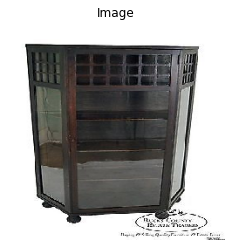

In [10]:
example = visualize_img(4, True)

# Load required functions and classes from Part 1

The below couple of cells are copy-pasted from Part 1.

In [11]:
def get_vector(model, layer, image):
    #    The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(512)
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.data.reshape(o.data.size(1)))
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 6. Run the model on our transformed image
    model(torch.tensor(image).unsqueeze(0).to(device))
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return my_embedding

# Metric Mapping

In [12]:
resnet_output_size = 512  # Length of item vector that will be indexed

def build_index(model, layer, model_name):
    skipped = 0
    saved = 0
    t = AnnoyIndex(resnet_output_size, 'angular')
    for idx, data in enumerate(tqdm(train_dataset)):
        img, class_id, super_class_id = data[0], data[1], data[2]
        if img is None:
            skipped += 1
            continue
        feature_v = get_vector(resnet18, layer, img)
        t.add_item(idx, feature_v)
        saved += 1
        
    print(f'Skipped {skipped} data points because of reading / transformation errors')
    print(f'Successfully saved {saved} data points in the index')

    t.build(12)  # 12 trees
    t.save(f'{model_name}-index.ann')
    
    return t


def load_index(idx_path):
    u = AnnoyIndex(resnet_output_size, 'angular')
    u.load('test.ann') # super fast, will just mmap the file
    # print(u.get_nns_by_item(0, 1000)) # will find the 1000 nearest neighbors
    return u

In [13]:
def evaluate(valid_dataset, layer, annoy_idx):
    # calculate ranked accuracy
    tp_class_id = 0
    tp_super_class_id = 0
    total = 0
    map_score_class_id = 0
    map_score_superclass_id = 0
    map_total = 0
    for idx, data in enumerate(tqdm(valid_dataset)):
        img, main_class_id, main_super_class_id = data[0], data[1], data[2]
        if img is None:
            continue
        feature_v = get_vector(resnet18, layer, img) 
        neighbours = annoy_idx.get_nns_by_vector(feature_v, 6)[1:]  # get top 5 closest
        
        ap_score_class_id = 0
        ap_score_superclass_id = 0
        ap_total = 0
        local_tp_class_id = 0
        local_tp_super_class_id = 0
 
        for neighbour in neighbours:
            _, class_id, super_class_id = train_dataset[neighbour]
            
            total += 1
            ap_total += 1
            
            if class_id == main_class_id:
                local_tp_class_id += 1
                ap_score_class_id += local_tp_class_id / ap_total
            if super_class_id == main_super_class_id:
                local_tp_super_class_id += 1
                ap_score_superclass_id += local_tp_super_class_id / ap_total
        
        tp_class_id += local_tp_class_id
        tp_super_class_id += local_tp_super_class_id
        
        map_score_class_id += ap_score_class_id / len(neighbours)  # divide by the number of predictions
        map_score_superclass_id += ap_score_superclass_id / len(neighbours)  # divide by the number of predictions
        map_total += 1
    
    print(f'Ranked Top-5 accuracy for Class ID: {round(tp_class_id / total, 2)}')
    print(f'Ranked Top-5 accuracy for Superclass ID: {round(tp_super_class_id / total, 2)}')
        
    print(f'\nmAP5 for Class ID: {round(map_score_class_id / map_total, 2)}')
    print(f'mAP5 for Superclass ID: {round(map_score_superclass_id / map_total, 2)}')

In [14]:
def visualize_retrieval(model, layer, annoy_idx):
    rows, cols = 5, 5
    f, axarr = plt.subplots(rows, cols)
    for row in range(rows):
        img_idx = random.randint(0, 40000)
        img, main_class_id, main_super_class_id = test_dataset[img_idx]
        feature_v = get_vector(model, layer, img)
        neightbours = annoy_idx.get_nns_by_vector(feature_v, 5)[1:]
        axarr[row, 0].imshow(np.transpose(img, (1, 2, 0)))
        axarr[row, 0].axis('off')
        axarr[row, 0].set_title(f'Superclass {main_super_class_id}\nClass {main_class_id}')

        for col in range(1, cols):
            axarr[row, col].axis('off')
            if col - 1 >= len(neightbours):
                break
            img, class_id, super_class_id = train_dataset[neightbours[col-1]]
            axarr[row, col].imshow(np.transpose(img, (1, 2, 0)))
            axarr[row, col].spines['bottom'].set_color('0.5')
            axarr[row, col].set_title(f'Superclass {super_class_id}\nClass {class_id}')

    plt.rcParams['figure.figsize'] = [15, 10]
    plt.subplots_adjust(top=1.4, bottom=0.01)
    line = plt.Line2D((.27,.27),(0,1.4), color="g", linewidth=5)
    f.add_artist(line)

# Task 3. Fine-tune using ArcFace Loss

In [15]:
num_classes = 11319
embedding_size = 512

resnet18 = models.resnet18(pretrained=True)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, embedding_size)

resnet18 = resnet18.to(device)
model_optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(model_optimizer, step_size=7, gamma=0.1)

# ArcFace Loss! We need a separete optimizer for it
loss_func = losses.ArcFaceLoss(num_classes, embedding_size).to(device)
loss_optimizer = torch.optim.SGD(loss_func.parameters(), lr=0.01)

In [16]:
data_loaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True, num_workers=4)
}

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(valid_dataset),
}

In [17]:
def train_arcface(model, model_optimizer, scheduler, loss_func, loss_optimizer, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    loss_train_history = list()
    loss_valid_history = list()
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            # Iterate over data.
            for data in tqdm(data_loaders[phase]):
                img, main_class_id, main_super_class_id = data[0], data[1], data[2]
                main_class_id -= 1
                
                try:
                    inputs = img.to(device)
                    labels = main_class_id.to(device)
                except:
                    print('Cannot move to device, skipping')
                    
                # zero the parameter gradients
                model_optimizer.zero_grad()
                loss_optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    embeddings = model(inputs)
                    
                    loss = loss_func(embeddings, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        model_optimizer.step()
                        loss_optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                
            epoch_loss = running_loss / dataset_sizes[phase]
                
            if phase == 'train':
                scheduler.step()
                loss_train_history.append(epoch_loss)
            else:
                loss_valid_history.append(epoch_loss)

            print(f'{phase} Loss: {epoch_loss:.4f}')
            
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_train_history, loss_valid_history

In [18]:
resnet18_arc_loss, arc_loss_train_history, arc_loss_valid_history = \
    train_arcface(resnet18, model_optimizer, exp_lr_scheduler, loss_func, loss_optimizer, num_epochs=100)

Epoch 0/99
----------


100%|████| 745/745 [01:30<00:00,  8.25it/s]


train Loss: 42.1118


100%|████| 187/187 [00:09<00:00, 20.24it/s]


val Loss: 41.7431

Epoch 1/99
----------


100%|████| 745/745 [01:33<00:00,  7.98it/s]


train Loss: 41.5598


100%|████| 187/187 [00:09<00:00, 20.21it/s]


val Loss: 41.4581

Epoch 2/99
----------


100%|████| 745/745 [01:34<00:00,  7.87it/s]


train Loss: 41.0964


100%|████| 187/187 [00:09<00:00, 19.98it/s]


val Loss: 41.0158

Epoch 3/99
----------


100%|████| 745/745 [01:34<00:00,  7.87it/s]


train Loss: 40.3341


100%|████| 187/187 [00:09<00:00, 19.54it/s]


val Loss: 40.4497

Epoch 4/99
----------


100%|████| 745/745 [01:34<00:00,  7.87it/s]


train Loss: 39.2975


100%|████| 187/187 [00:09<00:00, 19.44it/s]


val Loss: 39.7978

Epoch 5/99
----------


100%|████| 745/745 [01:39<00:00,  7.50it/s]


train Loss: 38.1963


100%|████| 187/187 [00:10<00:00, 17.09it/s]


val Loss: 39.2422

Epoch 6/99
----------


100%|████| 745/745 [01:34<00:00,  7.84it/s]


train Loss: 37.1666


100%|████| 187/187 [00:09<00:00, 19.36it/s]


val Loss: 38.7522

Epoch 7/99
----------


100%|████| 745/745 [01:37<00:00,  7.67it/s]


train Loss: 35.1876


100%|████| 187/187 [00:11<00:00, 15.68it/s]


val Loss: 38.0143

Epoch 8/99
----------


100%|████| 745/745 [01:40<00:00,  7.44it/s]


train Loss: 34.8173


100%|████| 187/187 [00:12<00:00, 15.29it/s]


val Loss: 37.9027

Epoch 9/99
----------


100%|████| 745/745 [01:39<00:00,  7.46it/s]


train Loss: 34.5852


100%|████| 187/187 [00:12<00:00, 14.85it/s]


val Loss: 37.8358

Epoch 10/99
----------


100%|████| 745/745 [01:39<00:00,  7.50it/s]


train Loss: 34.3884


100%|████| 187/187 [00:12<00:00, 14.79it/s]


val Loss: 37.7410

Epoch 11/99
----------


100%|████| 745/745 [01:38<00:00,  7.59it/s]


train Loss: 34.2146


100%|████| 187/187 [00:09<00:00, 19.68it/s]


val Loss: 37.6875

Epoch 12/99
----------


100%|████| 745/745 [01:35<00:00,  7.83it/s]


train Loss: 34.0265


100%|████| 187/187 [00:09<00:00, 19.81it/s]


val Loss: 37.6173

Epoch 13/99
----------


100%|████| 745/745 [01:34<00:00,  7.85it/s]


train Loss: 33.8598


100%|████| 187/187 [00:09<00:00, 19.91it/s]


val Loss: 37.5427

Epoch 14/99
----------


100%|████| 745/745 [01:35<00:00,  7.84it/s]


train Loss: 33.5456


100%|████| 187/187 [00:09<00:00, 19.75it/s]


val Loss: 37.5116

Epoch 15/99
----------


100%|████| 745/745 [01:35<00:00,  7.84it/s]


train Loss: 33.4873


100%|████| 187/187 [00:09<00:00, 20.03it/s]


val Loss: 37.4832

Epoch 16/99
----------


100%|████| 745/745 [01:34<00:00,  7.87it/s]


train Loss: 33.4743


100%|████| 187/187 [00:09<00:00, 19.62it/s]


val Loss: 37.4557

Epoch 17/99
----------


100%|████| 745/745 [01:34<00:00,  7.84it/s]


train Loss: 33.4408


100%|████| 187/187 [00:09<00:00, 19.72it/s]


val Loss: 37.4719

Epoch 18/99
----------


100%|████| 745/745 [01:34<00:00,  7.86it/s]


train Loss: 33.4217


100%|████| 187/187 [00:09<00:00, 19.89it/s]


val Loss: 37.4542

Epoch 19/99
----------


100%|████| 745/745 [01:34<00:00,  7.85it/s]


train Loss: 33.4047


100%|████| 187/187 [00:09<00:00, 19.83it/s]


val Loss: 37.4556

Epoch 20/99
----------


100%|████| 745/745 [01:35<00:00,  7.84it/s]


train Loss: 33.3697


100%|████| 187/187 [00:09<00:00, 19.51it/s]


val Loss: 37.4379

Epoch 21/99
----------


100%|████| 745/745 [01:34<00:00,  7.85it/s]


train Loss: 33.3349


100%|████| 187/187 [00:09<00:00, 19.89it/s]


val Loss: 37.4338

Epoch 22/99
----------


100%|████| 745/745 [01:34<00:00,  7.85it/s]


train Loss: 33.3321


100%|████| 187/187 [00:09<00:00, 19.75it/s]


val Loss: 37.4264

Epoch 23/99
----------


100%|████| 745/745 [01:35<00:00,  7.84it/s]


train Loss: 33.3344


100%|████| 187/187 [00:09<00:00, 19.85it/s]


val Loss: 37.4171

Epoch 24/99
----------


100%|████| 745/745 [01:35<00:00,  7.84it/s]


train Loss: 33.3276


100%|████| 187/187 [00:09<00:00, 19.83it/s]


val Loss: 37.4275

Epoch 25/99
----------


100%|████| 745/745 [01:34<00:00,  7.85it/s]


train Loss: 33.3291


100%|████| 187/187 [00:09<00:00, 19.68it/s]


val Loss: 37.4258

Epoch 26/99
----------


100%|████| 745/745 [01:35<00:00,  7.83it/s]


train Loss: 33.3074


100%|████| 187/187 [00:09<00:00, 19.44it/s]


val Loss: 37.4154

Epoch 27/99
----------


100%|████| 745/745 [01:35<00:00,  7.84it/s]


train Loss: 33.3181


100%|████| 187/187 [00:09<00:00, 19.80it/s]


val Loss: 37.4140

Epoch 28/99
----------


100%|████| 745/745 [01:34<00:00,  7.85it/s]


train Loss: 33.3089


100%|████| 187/187 [00:09<00:00, 19.66it/s]


val Loss: 37.4073

Epoch 29/99
----------


100%|████| 745/745 [01:34<00:00,  7.84it/s]


train Loss: 33.3064


100%|████| 187/187 [00:09<00:00, 19.69it/s]


val Loss: 37.4070

Epoch 30/99
----------


100%|████| 745/745 [01:35<00:00,  7.84it/s]


train Loss: 33.3083


100%|████| 187/187 [00:09<00:00, 19.80it/s]


val Loss: 37.4406

Epoch 31/99
----------


100%|████| 745/745 [01:35<00:00,  7.84it/s]


train Loss: 33.2929


100%|████| 187/187 [00:09<00:00, 19.84it/s]


val Loss: 37.4172

Epoch 32/99
----------


100%|████| 745/745 [01:35<00:00,  7.84it/s]


train Loss: 33.3100


100%|████| 187/187 [00:09<00:00, 19.85it/s]


val Loss: 37.4241

Epoch 33/99
----------


100%|████| 745/745 [01:35<00:00,  7.82it/s]


train Loss: 33.2954


100%|████| 187/187 [00:09<00:00, 19.75it/s]


val Loss: 37.4219

Epoch 34/99
----------


100%|████| 745/745 [01:34<00:00,  7.85it/s]


train Loss: 33.3093


100%|████| 187/187 [00:09<00:00, 19.80it/s]


val Loss: 37.4186

Epoch 35/99
----------


100%|████| 745/745 [01:35<00:00,  7.84it/s]


train Loss: 33.2890


100%|████| 187/187 [00:09<00:00, 19.92it/s]


val Loss: 37.4182

Epoch 36/99
----------


100%|████| 745/745 [01:34<00:00,  7.85it/s]


train Loss: 33.2890


100%|████| 187/187 [00:09<00:00, 19.58it/s]


val Loss: 37.4235

Epoch 37/99
----------


100%|████| 745/745 [01:35<00:00,  7.84it/s]


train Loss: 33.2804


100%|████| 187/187 [00:09<00:00, 19.70it/s]


val Loss: 37.4339

Epoch 38/99
----------


100%|████| 745/745 [01:34<00:00,  7.86it/s]


train Loss: 33.2795


100%|████| 187/187 [00:09<00:00, 19.56it/s]


val Loss: 37.4118

Epoch 39/99
----------


100%|████| 745/745 [01:34<00:00,  7.86it/s]


train Loss: 33.2779


100%|████| 187/187 [00:09<00:00, 19.73it/s]


val Loss: 37.4166

Epoch 40/99
----------


100%|████| 745/745 [01:34<00:00,  7.86it/s]


train Loss: 33.2706


100%|████| 187/187 [00:09<00:00, 19.73it/s]


val Loss: 37.4135

Epoch 41/99
----------


100%|████| 745/745 [01:34<00:00,  7.86it/s]


train Loss: 33.2763


100%|████| 187/187 [00:09<00:00, 19.92it/s]


val Loss: 37.3972

Epoch 42/99
----------


100%|████| 745/745 [01:34<00:00,  7.85it/s]


train Loss: 33.2773


100%|████| 187/187 [00:09<00:00, 19.95it/s]


val Loss: 37.4080

Epoch 43/99
----------


100%|████| 745/745 [01:34<00:00,  7.86it/s]


train Loss: 33.2642


100%|████| 187/187 [00:09<00:00, 19.63it/s]


val Loss: 37.4230

Epoch 44/99
----------


100%|████| 745/745 [01:34<00:00,  7.85it/s]


train Loss: 33.2686


100%|████| 187/187 [00:09<00:00, 19.88it/s]


val Loss: 37.3927

Epoch 45/99
----------


100%|████| 745/745 [01:34<00:00,  7.85it/s]


train Loss: 33.2681


100%|████| 187/187 [00:09<00:00, 19.80it/s]


val Loss: 37.4071

Epoch 46/99
----------


100%|████| 745/745 [01:34<00:00,  7.85it/s]


train Loss: 33.2684


100%|████| 187/187 [00:09<00:00, 19.83it/s]


val Loss: 37.3934

Epoch 47/99
----------


100%|████| 745/745 [01:35<00:00,  7.84it/s]


train Loss: 33.2583


100%|████| 187/187 [00:09<00:00, 19.67it/s]


val Loss: 37.3838

Epoch 48/99
----------


100%|████| 745/745 [01:34<00:00,  7.86it/s]


train Loss: 33.2607


100%|████| 187/187 [00:09<00:00, 19.92it/s]


val Loss: 37.3957

Epoch 49/99
----------


100%|████| 745/745 [01:34<00:00,  7.85it/s]


train Loss: 33.2551


100%|████| 187/187 [00:09<00:00, 19.82it/s]


val Loss: 37.3991

Epoch 50/99
----------


100%|████| 745/745 [01:34<00:00,  7.86it/s]


train Loss: 33.2566


100%|████| 187/187 [00:09<00:00, 19.96it/s]


val Loss: 37.3837

Epoch 51/99
----------


100%|████| 745/745 [01:34<00:00,  7.85it/s]


train Loss: 33.2563


100%|████| 187/187 [00:09<00:00, 19.73it/s]


val Loss: 37.3787

Epoch 52/99
----------


100%|████| 745/745 [01:34<00:00,  7.84it/s]


train Loss: 33.2365


100%|████| 187/187 [00:09<00:00, 19.87it/s]


val Loss: 37.3924

Epoch 53/99
----------


100%|████| 745/745 [01:35<00:00,  7.84it/s]


train Loss: 33.2554


100%|████| 187/187 [00:09<00:00, 19.30it/s]


val Loss: 37.3907

Epoch 54/99
----------


100%|████| 745/745 [01:34<00:00,  7.86it/s]


train Loss: 33.2451


100%|████| 187/187 [00:09<00:00, 19.52it/s]


val Loss: 37.3672

Epoch 55/99
----------


100%|████| 745/745 [01:34<00:00,  7.86it/s]


train Loss: 33.2510


100%|████| 187/187 [00:09<00:00, 20.06it/s]


val Loss: 37.3831

Epoch 56/99
----------


100%|████| 745/745 [01:34<00:00,  7.88it/s]


train Loss: 33.2560


100%|████| 187/187 [00:09<00:00, 19.88it/s]


val Loss: 37.3945

Epoch 57/99
----------


100%|████| 745/745 [01:34<00:00,  7.88it/s]


train Loss: 33.2409


100%|████| 187/187 [00:09<00:00, 19.80it/s]


val Loss: 37.3801

Epoch 58/99
----------


100%|████| 745/745 [01:34<00:00,  7.87it/s]


train Loss: 33.2441


100%|████| 187/187 [00:09<00:00, 19.77it/s]


val Loss: 37.3693

Epoch 59/99
----------


100%|████| 745/745 [01:34<00:00,  7.88it/s]


train Loss: 33.2220


100%|████| 187/187 [00:09<00:00, 20.07it/s]


val Loss: 37.3863

Epoch 60/99
----------


100%|████| 745/745 [01:34<00:00,  7.87it/s]


train Loss: 33.2407


100%|████| 187/187 [00:09<00:00, 19.87it/s]


val Loss: 37.3794

Epoch 61/99
----------


100%|████| 745/745 [01:34<00:00,  7.87it/s]


train Loss: 33.2360


100%|████| 187/187 [00:09<00:00, 19.98it/s]


val Loss: 37.3619

Epoch 62/99
----------


100%|████| 745/745 [01:34<00:00,  7.88it/s]


train Loss: 33.2374


100%|████| 187/187 [00:09<00:00, 20.02it/s]


val Loss: 37.3567

Epoch 63/99
----------


100%|████| 745/745 [01:34<00:00,  7.87it/s]


train Loss: 33.2270


100%|████| 187/187 [00:09<00:00, 19.70it/s]


val Loss: 37.3514

Epoch 64/99
----------


100%|████| 745/745 [01:34<00:00,  7.87it/s]


train Loss: 33.2273


100%|████| 187/187 [00:09<00:00, 20.04it/s]


val Loss: 37.3654

Epoch 65/99
----------


100%|████| 745/745 [01:34<00:00,  7.86it/s]


train Loss: 33.2296


100%|████| 187/187 [00:09<00:00, 20.05it/s]


val Loss: 37.3636

Epoch 66/99
----------


100%|████| 745/745 [01:34<00:00,  7.87it/s]


train Loss: 33.2171


100%|████| 187/187 [00:09<00:00, 19.99it/s]


val Loss: 37.3776

Epoch 67/99
----------


100%|████| 745/745 [01:34<00:00,  7.88it/s]


train Loss: 33.2319


100%|████| 187/187 [00:09<00:00, 19.99it/s]


val Loss: 37.3575

Epoch 68/99
----------


100%|████| 745/745 [01:34<00:00,  7.87it/s]


train Loss: 33.2217


100%|████| 187/187 [00:09<00:00, 20.14it/s]


val Loss: 37.3661

Epoch 69/99
----------


100%|████| 745/745 [01:34<00:00,  7.88it/s]


train Loss: 33.2113


100%|████| 187/187 [00:09<00:00, 19.83it/s]


val Loss: 37.3689

Epoch 70/99
----------


100%|████| 745/745 [01:34<00:00,  7.88it/s]


train Loss: 33.2159


100%|████| 187/187 [00:09<00:00, 19.85it/s]


val Loss: 37.3611

Epoch 71/99
----------


100%|████| 745/745 [01:34<00:00,  7.88it/s]


train Loss: 33.2159


100%|████| 187/187 [00:09<00:00, 19.81it/s]


val Loss: 37.3765

Epoch 72/99
----------


100%|████| 745/745 [01:34<00:00,  7.87it/s]


train Loss: 33.2170


100%|████| 187/187 [00:09<00:00, 20.08it/s]


val Loss: 37.3605

Epoch 73/99
----------


100%|████| 745/745 [01:34<00:00,  7.87it/s]


train Loss: 33.2150


100%|████| 187/187 [00:09<00:00, 20.00it/s]


val Loss: 37.3593

Epoch 74/99
----------


100%|████| 745/745 [01:34<00:00,  7.87it/s]


train Loss: 33.2276


100%|████| 187/187 [00:09<00:00, 20.03it/s]


val Loss: 37.3335

Epoch 75/99
----------


100%|████| 745/745 [01:34<00:00,  7.87it/s]


train Loss: 33.2136


100%|████| 187/187 [00:09<00:00, 19.68it/s]


val Loss: 37.3538

Epoch 76/99
----------


100%|████| 745/745 [01:34<00:00,  7.87it/s]


train Loss: 33.2057


100%|████| 187/187 [00:09<00:00, 19.95it/s]


val Loss: 37.3346

Epoch 77/99
----------


100%|████| 745/745 [01:34<00:00,  7.87it/s]


train Loss: 33.1963


100%|████| 187/187 [00:09<00:00, 20.06it/s]


val Loss: 37.3428

Epoch 78/99
----------


100%|████| 745/745 [01:34<00:00,  7.87it/s]


train Loss: 33.1929


100%|████| 187/187 [00:09<00:00, 19.93it/s]


val Loss: 37.3618

Epoch 79/99
----------


100%|████| 745/745 [01:34<00:00,  7.87it/s]


train Loss: 33.1969


100%|████| 187/187 [00:09<00:00, 19.93it/s]


val Loss: 37.3386

Epoch 80/99
----------


100%|████| 745/745 [01:34<00:00,  7.87it/s]


train Loss: 33.2046


100%|████| 187/187 [00:09<00:00, 19.75it/s]


val Loss: 37.3673

Epoch 81/99
----------


100%|████| 745/745 [01:34<00:00,  7.88it/s]


train Loss: 33.2103


100%|████| 187/187 [00:09<00:00, 19.72it/s]


val Loss: 37.3455

Epoch 82/99
----------


100%|████| 745/745 [01:34<00:00,  7.87it/s]


train Loss: 33.1833


100%|████| 187/187 [00:09<00:00, 19.91it/s]


val Loss: 37.3553

Epoch 83/99
----------


100%|████| 745/745 [01:34<00:00,  7.87it/s]


train Loss: 33.1863


100%|████| 187/187 [00:09<00:00, 19.85it/s]


val Loss: 37.3317

Epoch 84/99
----------


100%|████| 745/745 [01:34<00:00,  7.88it/s]


train Loss: 33.1925


100%|████| 187/187 [00:09<00:00, 19.95it/s]


val Loss: 37.3443

Epoch 85/99
----------


100%|████| 745/745 [01:34<00:00,  7.89it/s]


train Loss: 33.1819


100%|████| 187/187 [00:09<00:00, 19.49it/s]


val Loss: 37.3544

Epoch 86/99
----------


100%|████| 745/745 [01:34<00:00,  7.88it/s]


train Loss: 33.1881


100%|████| 187/187 [00:09<00:00, 19.94it/s]


val Loss: 37.3515

Epoch 87/99
----------


100%|████| 745/745 [01:34<00:00,  7.88it/s]


train Loss: 33.1871


100%|████| 187/187 [00:09<00:00, 19.99it/s]


val Loss: 37.3322

Epoch 88/99
----------


100%|████| 745/745 [01:34<00:00,  7.89it/s]


train Loss: 33.1846


100%|████| 187/187 [00:09<00:00, 20.05it/s]


val Loss: 37.3453

Epoch 89/99
----------


100%|████| 745/745 [01:34<00:00,  7.87it/s]


train Loss: 33.1858


100%|████| 187/187 [00:09<00:00, 20.00it/s]


val Loss: 37.3604

Epoch 90/99
----------


100%|████| 745/745 [01:34<00:00,  7.87it/s]


train Loss: 33.1722


100%|████| 187/187 [00:09<00:00, 20.07it/s]


val Loss: 37.3615

Epoch 91/99
----------


100%|████| 745/745 [01:34<00:00,  7.88it/s]


train Loss: 33.1791


100%|████| 187/187 [00:09<00:00, 19.87it/s]


val Loss: 37.3232

Epoch 92/99
----------


100%|████| 745/745 [01:34<00:00,  7.87it/s]


train Loss: 33.1771


100%|████| 187/187 [00:09<00:00, 19.87it/s]


val Loss: 37.3471

Epoch 93/99
----------


100%|████| 745/745 [01:34<00:00,  7.87it/s]


train Loss: 33.1699


100%|████| 187/187 [00:09<00:00, 19.72it/s]


val Loss: 37.3622

Epoch 94/99
----------


100%|████| 745/745 [01:34<00:00,  7.87it/s]


train Loss: 33.1633


100%|████| 187/187 [00:09<00:00, 19.82it/s]


val Loss: 37.3369

Epoch 95/99
----------


100%|████| 745/745 [01:34<00:00,  7.88it/s]


train Loss: 33.1596


100%|████| 187/187 [00:09<00:00, 20.07it/s]


val Loss: 37.3292

Epoch 96/99
----------


100%|████| 745/745 [01:34<00:00,  7.88it/s]


train Loss: 33.1634


100%|████| 187/187 [00:09<00:00, 19.75it/s]


val Loss: 37.3281

Epoch 97/99
----------


100%|████| 745/745 [01:34<00:00,  7.88it/s]


train Loss: 33.1518


100%|████| 187/187 [00:09<00:00, 19.85it/s]


val Loss: 37.3432

Epoch 98/99
----------


100%|████| 745/745 [01:34<00:00,  7.88it/s]


train Loss: 33.1714


100%|████| 187/187 [00:09<00:00, 19.63it/s]


val Loss: 37.3227

Epoch 99/99
----------


100%|████| 745/745 [01:34<00:00,  7.88it/s]


train Loss: 33.1597


100%|████| 187/187 [00:09<00:00, 19.89it/s]

val Loss: 37.3247

Training complete in 174m 14s


Text(0.5, 1.0, 'Train Loss (red) vs Valid Loss (green)')

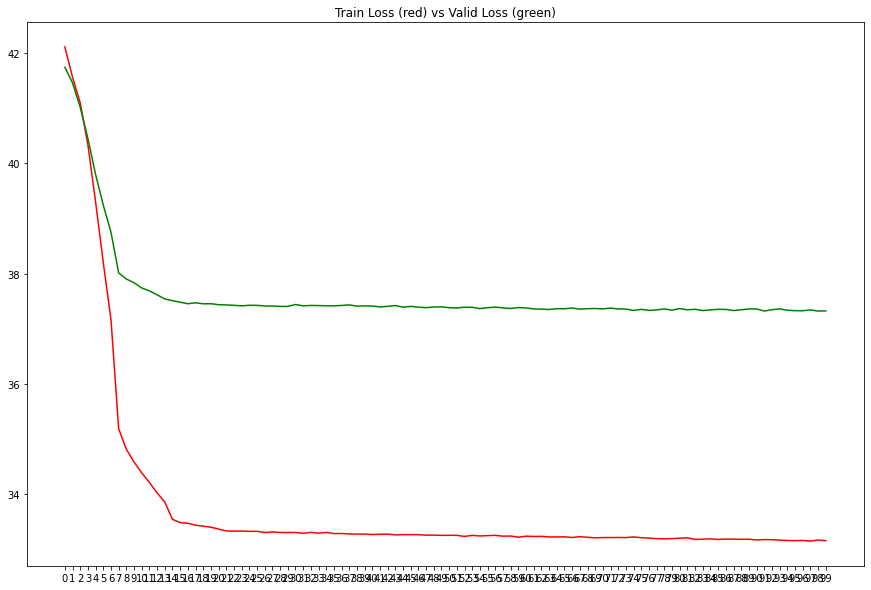

In [19]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.plot(arc_loss_train_history, c='r')
plt.plot(arc_loss_valid_history, c='g')
plt.xticks(range(len(arc_loss_train_history)))
plt.title('Train Loss (red) vs Valid Loss (green)')

In [20]:
# Use the model object to select the desired layer
layer_arc_loss = resnet18_arc_loss._modules.get('avgpool')

# Set model to evaluation mode
resnet18_arc_loss.eval()

checkpoint = {'state_dict': resnet18_arc_loss.state_dict(), 'optimizer': model_optimizer.state_dict()}
torch.save(checkpoint, 'arcface-resnet.pth')

In [21]:
feature_v = get_vector(resnet18_arc_loss, layer_arc_loss, example)
feature_v.shape

torch.Size([512])

In [22]:
annoy_arcloss_index = build_index(resnet18_arc_loss, layer_arc_loss, 'arcface-finetune-resnet18')
annoy_arcloss_index.get_nns_by_item(0, 5)

100%|█| 47640/47640 [04:22<00:00, 181.26it/


Skipped 0 data points because of reading / transformation errors
Successfully saved 47640 data points in the index


[0, 3178, 34904, 24881, 42499]

In [23]:
evaluate(valid_dataset, layer_arc_loss, annoy_arcloss_index)

100%|█| 11911/11911 [03:24<00:00, 58.30it/s

Ranked Top-5 accuracy for Class ID: 0.11
Ranked Top-5 accuracy for Superclass ID: 0.51

mAP5 for Class ID: 0.09
mAP5 for Superclass ID: 0.45


### Top-5 Accuracy for Class ID is 11% (the biggest one I was able to achieve across all models), for Superclass ID it's 51%.
### mAP5 for Class ID is 9%, for Superclass ID it's 45%.

## Visualize

The below visualization shows the anchor image (on the left) and retrieved 4 images on the right based on index.

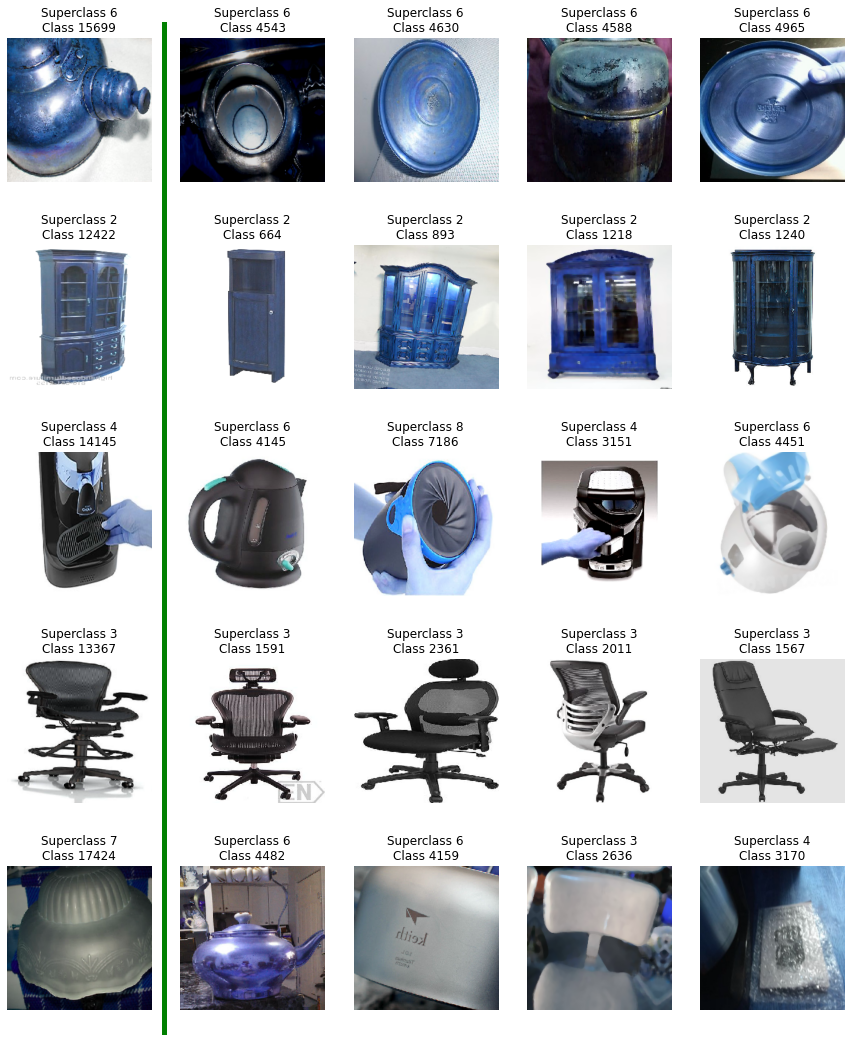

In [24]:
visualize_retrieval(resnet18_arc_loss, layer_arc_loss, annoy_arcloss_index)

# Task 4. Fine-tune using Contrastive Loss

In [25]:
num_classes = 11319
embedding_size = 512

resnet18 = models.resnet18(pretrained=True)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, embedding_size)

resnet18 = resnet18.to(device)
model_optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(model_optimizer, step_size=7, gamma=0.1)

## Initialize Contrastive Loss

In [26]:
contrastive_loss = losses.ContrastiveLoss().to(device)

In [27]:
def train_cotrastive(model, model_optimizer, scheduler, loss_func, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    
    loss_train_history = list()
    loss_valid_history = list()
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            # Iterate over data.
            for data in tqdm(data_loaders[phase]):
                img, main_class_id, main_super_class_id = data[0], data[1], data[2]
                main_class_id -= 1
                
                try:
                    inputs = img.to(device)
                    labels = main_class_id.to(device)
                except:
                    print('Cannot move to device, skipping')
                    
                # zero the parameter gradients
                model_optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    embeddings = model(inputs)
                    
                    loss = loss_func(embeddings, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        model_optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            
            epoch_loss = running_loss / dataset_sizes[phase]
                
            if phase == 'train':
                scheduler.step()
                loss_train_history.append(epoch_loss)
            else:
                loss_valid_history.append(epoch_loss)
                
            print(f'{phase} Loss: {epoch_loss:.4f}')
            
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_train_history, loss_valid_history

In [28]:
resnet18_contrast_loss, contrast_loss_train_history, contrast_loss_valid_history = \
    train_cotrastive(resnet18, model_optimizer, exp_lr_scheduler, contrastive_loss, num_epochs=100
                    )

Epoch 0/99
----------


100%|████| 745/745 [01:29<00:00,  8.33it/s]


train Loss: 0.1925


100%|████| 187/187 [00:09<00:00, 20.20it/s]


val Loss: 0.1402

Epoch 1/99
----------


100%|████| 745/745 [01:32<00:00,  8.08it/s]


train Loss: 0.2143


100%|████| 187/187 [00:09<00:00, 19.98it/s]


val Loss: 0.0695

Epoch 2/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.1999


100%|████| 187/187 [00:09<00:00, 19.72it/s]


val Loss: 0.1333

Epoch 3/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.1885


100%|████| 187/187 [00:09<00:00, 19.96it/s]


val Loss: 0.0919

Epoch 4/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.2063


100%|████| 187/187 [00:09<00:00, 19.95it/s]


val Loss: 0.1045

Epoch 5/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.1853


100%|████| 187/187 [00:09<00:00, 19.87it/s]


val Loss: 0.0999

Epoch 6/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.1864


100%|████| 187/187 [00:09<00:00, 19.93it/s]


val Loss: 0.1213

Epoch 7/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.1682


100%|████| 187/187 [00:09<00:00, 19.67it/s]


val Loss: 0.1134

Epoch 8/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.1919


100%|████| 187/187 [00:09<00:00, 19.95it/s]


val Loss: 0.1299

Epoch 9/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.2167


100%|████| 187/187 [00:09<00:00, 20.06it/s]


val Loss: 0.0798

Epoch 10/99
----------


100%|████| 745/745 [01:32<00:00,  8.03it/s]


train Loss: 0.1880


100%|████| 187/187 [00:09<00:00, 19.98it/s]


val Loss: 0.1214

Epoch 11/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.2244


100%|████| 187/187 [00:09<00:00, 19.98it/s]


val Loss: 0.1055

Epoch 12/99
----------


100%|████| 745/745 [01:32<00:00,  8.03it/s]


train Loss: 0.2049


100%|████| 187/187 [00:09<00:00, 19.91it/s]


val Loss: 0.0718

Epoch 13/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.2148


100%|████| 187/187 [00:09<00:00, 20.01it/s]


val Loss: 0.1086

Epoch 14/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.2046


100%|████| 187/187 [00:09<00:00, 19.82it/s]


val Loss: 0.1234

Epoch 15/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.1982


100%|████| 187/187 [00:09<00:00, 20.08it/s]


val Loss: 0.1084

Epoch 16/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.1774


100%|████| 187/187 [00:09<00:00, 19.98it/s]


val Loss: 0.1274

Epoch 17/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.2087


100%|████| 187/187 [00:09<00:00, 19.97it/s]


val Loss: 0.1021

Epoch 18/99
----------


100%|████| 745/745 [01:32<00:00,  8.03it/s]


train Loss: 0.2211


100%|████| 187/187 [00:09<00:00, 20.05it/s]


val Loss: 0.1079

Epoch 19/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.1785


100%|████| 187/187 [00:09<00:00, 20.01it/s]


val Loss: 0.1024

Epoch 20/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.1923


100%|████| 187/187 [00:09<00:00, 19.77it/s]


val Loss: 0.0987

Epoch 21/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.2117


100%|████| 187/187 [00:09<00:00, 19.91it/s]


val Loss: 0.0884

Epoch 22/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.2026


100%|████| 187/187 [00:09<00:00, 20.01it/s]


val Loss: 0.1188

Epoch 23/99
----------


100%|████| 745/745 [01:32<00:00,  8.06it/s]


train Loss: 0.2021


100%|████| 187/187 [00:09<00:00, 19.93it/s]


val Loss: 0.0915

Epoch 24/99
----------


100%|████| 745/745 [01:32<00:00,  8.06it/s]


train Loss: 0.2149


100%|████| 187/187 [00:09<00:00, 20.00it/s]


val Loss: 0.0764

Epoch 25/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.1917


100%|████| 187/187 [00:09<00:00, 19.94it/s]


val Loss: 0.1178

Epoch 26/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.2015


100%|████| 187/187 [00:09<00:00, 19.85it/s]


val Loss: 0.0992

Epoch 27/99
----------


100%|████| 745/745 [01:32<00:00,  8.03it/s]


train Loss: 0.1926


100%|████| 187/187 [00:09<00:00, 19.96it/s]


val Loss: 0.1032

Epoch 28/99
----------


100%|████| 745/745 [01:32<00:00,  8.03it/s]


train Loss: 0.2286


100%|████| 187/187 [00:09<00:00, 20.06it/s]


val Loss: 0.0686

Epoch 29/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.1975


100%|████| 187/187 [00:09<00:00, 20.03it/s]


val Loss: 0.1366

Epoch 30/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.2222


100%|████| 187/187 [00:09<00:00, 19.84it/s]


val Loss: 0.0764

Epoch 31/99
----------


100%|████| 745/745 [01:32<00:00,  8.06it/s]


train Loss: 0.2080


100%|████| 187/187 [00:09<00:00, 19.80it/s]


val Loss: 0.1119

Epoch 32/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.1602


100%|████| 187/187 [00:09<00:00, 19.85it/s]


val Loss: 0.0927

Epoch 33/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.1954


100%|████| 187/187 [00:09<00:00, 20.02it/s]


val Loss: 0.1304

Epoch 34/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.2025


100%|████| 187/187 [00:09<00:00, 20.01it/s]


val Loss: 0.1131

Epoch 35/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.1820


100%|████| 187/187 [00:09<00:00, 19.99it/s]


val Loss: 0.1310

Epoch 36/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.2070


100%|████| 187/187 [00:09<00:00, 20.00it/s]


val Loss: 0.0833

Epoch 37/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.2015


100%|████| 187/187 [00:09<00:00, 19.85it/s]


val Loss: 0.0954

Epoch 38/99
----------


100%|████| 745/745 [01:32<00:00,  8.06it/s]


train Loss: 0.1796


100%|████| 187/187 [00:09<00:00, 20.09it/s]


val Loss: 0.0962

Epoch 39/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.2162


100%|████| 187/187 [00:09<00:00, 20.02it/s]


val Loss: 0.1225

Epoch 40/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.2218


100%|████| 187/187 [00:09<00:00, 20.07it/s]


val Loss: 0.0995

Epoch 41/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.1815


100%|████| 187/187 [00:09<00:00, 19.97it/s]


val Loss: 0.1014

Epoch 42/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.1957


100%|████| 187/187 [00:09<00:00, 19.78it/s]


val Loss: 0.0861

Epoch 43/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.1927


100%|████| 187/187 [00:09<00:00, 19.94it/s]


val Loss: 0.0880

Epoch 44/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.2001


100%|████| 187/187 [00:09<00:00, 20.01it/s]


val Loss: 0.1164

Epoch 45/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.2067


100%|████| 187/187 [00:09<00:00, 19.97it/s]


val Loss: 0.0675

Epoch 46/99
----------


100%|████| 745/745 [01:32<00:00,  8.03it/s]


train Loss: 0.2076


100%|████| 187/187 [00:09<00:00, 19.88it/s]


val Loss: 0.1188

Epoch 47/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.1986


100%|████| 187/187 [00:09<00:00, 19.97it/s]


val Loss: 0.1063

Epoch 48/99
----------


100%|████| 745/745 [01:32<00:00,  8.02it/s]


train Loss: 0.2113


100%|████| 187/187 [00:09<00:00, 20.00it/s]


val Loss: 0.1113

Epoch 49/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.2029


100%|████| 187/187 [00:09<00:00, 19.87it/s]


val Loss: 0.0773

Epoch 50/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.1972


100%|████| 187/187 [00:09<00:00, 19.89it/s]


val Loss: 0.1044

Epoch 51/99
----------


100%|████| 745/745 [01:32<00:00,  8.03it/s]


train Loss: 0.2241


100%|████| 187/187 [00:09<00:00, 20.04it/s]


val Loss: 0.1081

Epoch 52/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.1994


100%|████| 187/187 [00:09<00:00, 19.76it/s]


val Loss: 0.1051

Epoch 53/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.2338


100%|████| 187/187 [00:09<00:00, 20.00it/s]


val Loss: 0.1357

Epoch 54/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.2199


100%|████| 187/187 [00:09<00:00, 19.97it/s]


val Loss: 0.0865

Epoch 55/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.2277


100%|████| 187/187 [00:09<00:00, 19.84it/s]


val Loss: 0.0770

Epoch 56/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.2292


100%|████| 187/187 [00:09<00:00, 19.91it/s]


val Loss: 0.0951

Epoch 57/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.1813


100%|████| 187/187 [00:09<00:00, 19.76it/s]


val Loss: 0.0743

Epoch 58/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.2079


100%|████| 187/187 [00:09<00:00, 20.04it/s]


val Loss: 0.0998

Epoch 59/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.2177


100%|████| 187/187 [00:09<00:00, 20.04it/s]


val Loss: 0.1231

Epoch 60/99
----------


100%|████| 745/745 [01:32<00:00,  8.06it/s]


train Loss: 0.1971


100%|████| 187/187 [00:09<00:00, 20.06it/s]


val Loss: 0.1491

Epoch 61/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.2010


100%|████| 187/187 [00:09<00:00, 19.86it/s]


val Loss: 0.1097

Epoch 62/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.1972


100%|████| 187/187 [00:09<00:00, 19.93it/s]


val Loss: 0.1127

Epoch 63/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.2027


100%|████| 187/187 [00:09<00:00, 20.08it/s]


val Loss: 0.0918

Epoch 64/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.1979


100%|████| 187/187 [00:09<00:00, 19.98it/s]


val Loss: 0.0670

Epoch 65/99
----------


100%|████| 745/745 [01:32<00:00,  8.06it/s]


train Loss: 0.1986


100%|████| 187/187 [00:09<00:00, 19.72it/s]


val Loss: 0.1015

Epoch 66/99
----------


100%|████| 745/745 [01:32<00:00,  8.06it/s]


train Loss: 0.2041


100%|████| 187/187 [00:09<00:00, 19.99it/s]


val Loss: 0.1126

Epoch 67/99
----------


100%|████| 745/745 [01:32<00:00,  8.03it/s]


train Loss: 0.2158


100%|████| 187/187 [00:09<00:00, 19.88it/s]


val Loss: 0.1227

Epoch 68/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.2461


100%|████| 187/187 [00:09<00:00, 20.07it/s]


val Loss: 0.1328

Epoch 69/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.1901


100%|████| 187/187 [00:09<00:00, 19.91it/s]


val Loss: 0.0966

Epoch 70/99
----------


100%|████| 745/745 [01:32<00:00,  8.02it/s]


train Loss: 0.2060


100%|████| 187/187 [00:09<00:00, 20.00it/s]


val Loss: 0.1289

Epoch 71/99
----------


100%|████| 745/745 [01:32<00:00,  8.06it/s]


train Loss: 0.1981


100%|████| 187/187 [00:09<00:00, 19.86it/s]


val Loss: 0.0720

Epoch 72/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.2151


100%|████| 187/187 [00:09<00:00, 19.91it/s]


val Loss: 0.1045

Epoch 73/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.2034


100%|████| 187/187 [00:09<00:00, 19.89it/s]


val Loss: 0.1094

Epoch 74/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.2092


100%|████| 187/187 [00:09<00:00, 19.90it/s]


val Loss: 0.1136

Epoch 75/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.2008


100%|████| 187/187 [00:09<00:00, 19.98it/s]


val Loss: 0.0920

Epoch 76/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.1849


100%|████| 187/187 [00:09<00:00, 19.72it/s]


val Loss: 0.0847

Epoch 77/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.1974


100%|████| 187/187 [00:09<00:00, 19.90it/s]


val Loss: 0.1107

Epoch 78/99
----------


100%|████| 745/745 [01:32<00:00,  8.03it/s]


train Loss: 0.2025


100%|████| 187/187 [00:09<00:00, 20.08it/s]


val Loss: 0.1265

Epoch 79/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.2085


100%|████| 187/187 [00:09<00:00, 19.90it/s]


val Loss: 0.1033

Epoch 80/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.1837


100%|████| 187/187 [00:09<00:00, 19.80it/s]


val Loss: 0.0600

Epoch 81/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.2340


100%|████| 187/187 [00:09<00:00, 19.79it/s]


val Loss: 0.1300

Epoch 82/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.1980


100%|████| 187/187 [00:09<00:00, 19.72it/s]


val Loss: 0.1225

Epoch 83/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.1911


100%|████| 187/187 [00:09<00:00, 20.00it/s]


val Loss: 0.1063

Epoch 84/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.2171


100%|████| 187/187 [00:09<00:00, 19.96it/s]


val Loss: 0.1220

Epoch 85/99
----------


100%|████| 745/745 [01:32<00:00,  8.06it/s]


train Loss: 0.2152


100%|████| 187/187 [00:09<00:00, 19.87it/s]


val Loss: 0.1047

Epoch 86/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.2036


100%|████| 187/187 [00:09<00:00, 19.87it/s]


val Loss: 0.1488

Epoch 87/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.2246


100%|████| 187/187 [00:09<00:00, 19.81it/s]


val Loss: 0.0695

Epoch 88/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.2061


100%|████| 187/187 [00:09<00:00, 19.96it/s]


val Loss: 0.1308

Epoch 89/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.1847


100%|████| 187/187 [00:09<00:00, 20.01it/s]


val Loss: 0.1034

Epoch 90/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.1781


100%|████| 187/187 [00:09<00:00, 19.89it/s]


val Loss: 0.0925

Epoch 91/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.2151


100%|████| 187/187 [00:09<00:00, 19.92it/s]


val Loss: 0.0837

Epoch 92/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.2130


100%|████| 187/187 [00:09<00:00, 20.03it/s]


val Loss: 0.1163

Epoch 93/99
----------


100%|████| 745/745 [01:32<00:00,  8.07it/s]


train Loss: 0.1796


100%|████| 187/187 [00:09<00:00, 20.01it/s]


val Loss: 0.1092

Epoch 94/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.1960


100%|████| 187/187 [00:09<00:00, 19.72it/s]


val Loss: 0.1425

Epoch 95/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.2041


100%|████| 187/187 [00:09<00:00, 19.94it/s]


val Loss: 0.0840

Epoch 96/99
----------


100%|████| 745/745 [01:32<00:00,  8.04it/s]


train Loss: 0.1918


100%|████| 187/187 [00:09<00:00, 19.96it/s]


val Loss: 0.0972

Epoch 97/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.1974


100%|████| 187/187 [00:09<00:00, 19.84it/s]


val Loss: 0.1278

Epoch 98/99
----------


100%|████| 745/745 [01:32<00:00,  8.06it/s]


train Loss: 0.2070


100%|████| 187/187 [00:09<00:00, 19.78it/s]


val Loss: 0.0790

Epoch 99/99
----------


100%|████| 745/745 [01:32<00:00,  8.05it/s]


train Loss: 0.2215


100%|████| 187/187 [00:09<00:00, 19.91it/s]

val Loss: 0.1102

Training complete in 169m 56s


In [30]:
# Use the model object to select the desired layer
layer_contrast_loss = resnet18_contrast_loss._modules.get('avgpool')

# Set model to evaluation mode
resnet18_contrast_loss.eval()

checkpoint = {'state_dict': resnet18_contrast_loss.state_dict(), 'optimizer': model_optimizer.state_dict()}
torch.save(checkpoint, 'contrastive-resnet.pth')

In [31]:
feature_v = get_vector(resnet18_contrast_loss, layer_contrast_loss, example)
feature_v.shape

torch.Size([512])

In [32]:
annoy_contrast_index = build_index(resnet18_contrast_loss, layer_contrast_loss, 'contrastive-finetune-resnet18')
annoy_contrast_index.get_nns_by_item(0, 5)

100%|█| 47640/47640 [04:24<00:00, 179.99it/


Skipped 0 data points because of reading / transformation errors
Successfully saved 47640 data points in the index


[0, 9661, 875, 460, 35451]

In [33]:
evaluate(valid_dataset, layer_contrast_loss, annoy_contrast_index)

100%|█| 11911/11911 [03:25<00:00, 57.83it/s

Ranked Top-5 accuracy for Class ID: 0.06
Ranked Top-5 accuracy for Superclass ID: 0.42

mAP5 for Class ID: 0.05
mAP5 for Superclass ID: 0.35


### Top-5 Accuracy for Class ID is 6%, for Superclass ID it's 42%.
### mAP5 for Class ID is 5%, for Superclass ID it's 35%.

This model performs the worst for some reason. It could not train well enough with this loss. Probably, more tweaking of loss is required.

## Visualize

The below visualization shows the anchor image (on the left) and retrieved 4 images on the right based on index.

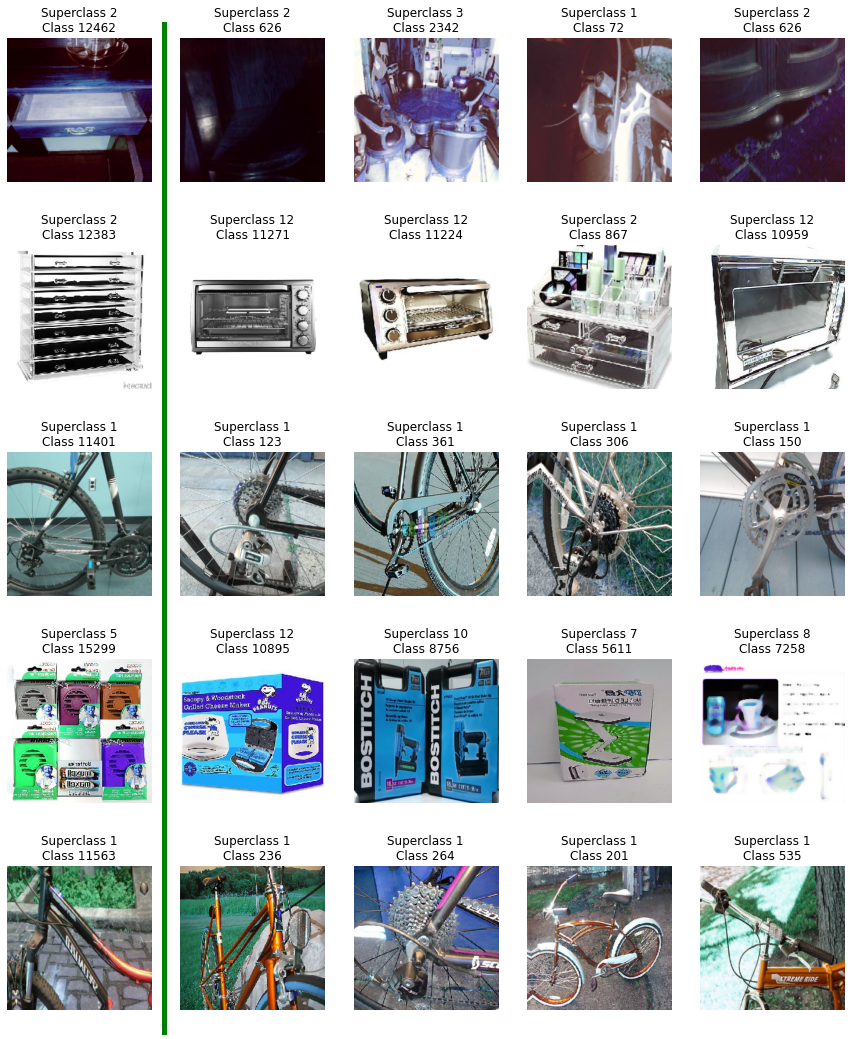

In [34]:
visualize_retrieval(resnet18_contrast_loss, layer_contrast_loss, annoy_contrast_index)

# Task 5. Fine-tune using Triplet Loss

In [35]:
num_classes = 11319
embedding_size = 512

resnet18 = models.resnet18(pretrained=True)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, embedding_size)

resnet18 = resnet18.to(device)
model_optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(model_optimizer, step_size=7, gamma=0.1)

## Initialize Triplet Loss

In [36]:
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer).to(device)
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="semihard"
)

In [37]:
def train_triplet(model, model_optimizer, scheduler, loss_func, mining_func, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    
    loss_train_history = list()
    loss_valid_history = list()
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            # Iterate over data.
            for data in tqdm(data_loaders[phase]):
                img, main_class_id, main_super_class_id = data[0], data[1], data[2]
                main_class_id -= 1
                
                try:
                    inputs = img.to(device)
                    labels = main_class_id.to(device)
                except:
                    print('Cannot move to device, skipping')
                    
                # zero the parameter gradients
                model_optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    embeddings = model(inputs)
                    
                    indices_tuple = mining_func(embeddings, labels)
                    loss = loss_func(embeddings, labels, indices_tuple)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        model_optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            
            epoch_loss = running_loss / dataset_sizes[phase]
                
            if phase == 'train':
                scheduler.step()
                loss_train_history.append(epoch_loss)
            else:
                loss_valid_history.append(epoch_loss)
                
            print(f'{phase} Loss: {epoch_loss:.4f}')
            
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_train_history, loss_valid_history

In [38]:
resnet18_triplet_loss, triplet_loss_train_history, triplet_loss_valid_history = \
    train_triplet(resnet18, model_optimizer, exp_lr_scheduler, loss_func, mining_func, num_epochs=15)

Epoch 0/99
----------


100%|████| 745/745 [01:28<00:00,  8.42it/s]


train Loss: 0.0055


100%|████| 187/187 [00:09<00:00, 20.45it/s]


val Loss: 0.0034

Epoch 1/99
----------


100%|████| 745/745 [01:31<00:00,  8.18it/s]


train Loss: 0.0061


100%|████| 187/187 [00:09<00:00, 20.23it/s]


val Loss: 0.0023

Epoch 2/99
----------


100%|████| 745/745 [01:31<00:00,  8.15it/s]


train Loss: 0.0045


100%|████| 187/187 [00:09<00:00, 20.00it/s]


val Loss: 0.0014

Epoch 3/99
----------


100%|████| 745/745 [01:31<00:00,  8.16it/s]


train Loss: 0.0053


100%|████| 187/187 [00:09<00:00, 20.29it/s]


val Loss: 0.0024

Epoch 4/99
----------


100%|████| 745/745 [01:31<00:00,  8.13it/s]


train Loss: 0.0057


100%|████| 187/187 [00:09<00:00, 20.20it/s]


val Loss: 0.0017

Epoch 5/99
----------


100%|████| 745/745 [01:31<00:00,  8.15it/s]


train Loss: 0.0047


100%|████| 187/187 [00:09<00:00, 20.22it/s]


val Loss: 0.0018

Epoch 6/99
----------


100%|████| 745/745 [01:31<00:00,  8.14it/s]


train Loss: 0.0037


100%|████| 187/187 [00:09<00:00, 19.98it/s]


val Loss: 0.0024

Epoch 7/99
----------


100%|████| 745/745 [01:31<00:00,  8.13it/s]


train Loss: 0.0051


100%|████| 187/187 [00:09<00:00, 20.11it/s]


val Loss: 0.0030

Epoch 8/99
----------


100%|████| 745/745 [01:31<00:00,  8.14it/s]


train Loss: 0.0040


100%|████| 187/187 [00:09<00:00, 20.16it/s]


val Loss: 0.0035

Epoch 9/99
----------


100%|████| 745/745 [01:31<00:00,  8.14it/s]


train Loss: 0.0047


100%|████| 187/187 [00:09<00:00, 20.11it/s]


val Loss: 0.0022

Epoch 10/99
----------


100%|████| 745/745 [01:31<00:00,  8.14it/s]


train Loss: 0.0058


100%|████| 187/187 [00:09<00:00, 20.32it/s]


val Loss: 0.0034

Epoch 11/99
----------


100%|████| 745/745 [01:31<00:00,  8.14it/s]


train Loss: 0.0052


100%|████| 187/187 [00:09<00:00, 20.15it/s]


val Loss: 0.0032

Epoch 12/99
----------


100%|████| 745/745 [01:31<00:00,  8.13it/s]


train Loss: 0.0055


100%|████| 187/187 [00:09<00:00, 20.19it/s]


val Loss: 0.0038

Epoch 13/99
----------


100%|████| 745/745 [01:31<00:00,  8.13it/s]


train Loss: 0.0064


100%|████| 187/187 [00:09<00:00, 20.24it/s]


val Loss: 0.0037

Epoch 14/99
----------


100%|████| 745/745 [01:31<00:00,  8.14it/s]


train Loss: 0.0049


100%|████| 187/187 [00:09<00:00, 20.30it/s]


val Loss: 0.0014

Epoch 15/99
----------


100%|████| 745/745 [01:31<00:00,  8.16it/s]


train Loss: 0.0049


100%|████| 187/187 [00:09<00:00, 19.92it/s]


val Loss: 0.0012

Epoch 16/99
----------


100%|████| 745/745 [01:31<00:00,  8.13it/s]


train Loss: 0.0047


100%|████| 187/187 [00:09<00:00, 20.21it/s]


val Loss: 0.0019

Epoch 17/99
----------


100%|████| 745/745 [01:31<00:00,  8.13it/s]


train Loss: 0.0060


100%|████| 187/187 [00:09<00:00, 20.25it/s]


val Loss: 0.0030

Epoch 18/99
----------


100%|████| 745/745 [01:31<00:00,  8.14it/s]


train Loss: 0.0043


100%|████| 187/187 [00:09<00:00, 19.78it/s]


val Loss: 0.0024

Epoch 19/99
----------


100%|████| 745/745 [01:31<00:00,  8.13it/s]


train Loss: 0.0051


100%|████| 187/187 [00:09<00:00, 20.15it/s]


val Loss: 0.0033

Epoch 20/99
----------


100%|████| 745/745 [01:31<00:00,  8.13it/s]


train Loss: 0.0049


100%|████| 187/187 [00:09<00:00, 20.25it/s]


val Loss: 0.0023

Epoch 21/99
----------


100%|████| 745/745 [01:31<00:00,  8.13it/s]


train Loss: 0.0049


100%|████| 187/187 [00:09<00:00, 20.14it/s]


val Loss: 0.0028

Epoch 22/99
----------


100%|████| 745/745 [01:31<00:00,  8.12it/s]


train Loss: 0.0042


100%|████| 187/187 [00:09<00:00, 20.23it/s]


val Loss: 0.0019

Epoch 23/99
----------


100%|████| 745/745 [01:31<00:00,  8.12it/s]


train Loss: 0.0047


100%|████| 187/187 [00:09<00:00, 20.24it/s]


val Loss: 0.0052

Epoch 24/99
----------


100%|████| 745/745 [01:31<00:00,  8.12it/s]


train Loss: 0.0047


100%|████| 187/187 [00:09<00:00, 20.08it/s]


val Loss: 0.0034

Epoch 25/99
----------


100%|████| 745/745 [01:31<00:00,  8.14it/s]


train Loss: 0.0042


100%|████| 187/187 [00:09<00:00, 20.10it/s]


val Loss: 0.0033

Epoch 26/99
----------


100%|████| 745/745 [01:31<00:00,  8.13it/s]


train Loss: 0.0048


100%|████| 187/187 [00:09<00:00, 20.21it/s]


val Loss: 0.0024

Epoch 27/99
----------


100%|████| 745/745 [01:31<00:00,  8.14it/s]


train Loss: 0.0038


100%|████| 187/187 [00:09<00:00, 19.99it/s]


val Loss: 0.0029

Epoch 28/99
----------


100%|████| 745/745 [01:31<00:00,  8.13it/s]


train Loss: 0.0039


100%|████| 187/187 [00:09<00:00, 20.38it/s]


val Loss: 0.0008

Epoch 29/99
----------


100%|████| 745/745 [01:31<00:00,  8.12it/s]


train Loss: 0.0063


100%|████| 187/187 [00:09<00:00, 20.18it/s]


val Loss: 0.0026

Epoch 30/99
----------


100%|████| 745/745 [01:31<00:00,  8.14it/s]


train Loss: 0.0046


100%|████| 187/187 [00:09<00:00, 19.83it/s]


val Loss: 0.0010

Epoch 31/99
----------


100%|████| 745/745 [01:31<00:00,  8.14it/s]


train Loss: 0.0055


100%|████| 187/187 [00:09<00:00, 20.35it/s]


val Loss: 0.0004

Epoch 32/99
----------


100%|████| 745/745 [01:31<00:00,  8.14it/s]


train Loss: 0.0044


100%|████| 187/187 [00:09<00:00, 20.21it/s]


val Loss: 0.0023

Epoch 33/99
----------


100%|████| 745/745 [01:31<00:00,  8.15it/s]


train Loss: 0.0051


100%|████| 187/187 [00:09<00:00, 20.09it/s]


val Loss: 0.0021

Epoch 34/99
----------


100%|████| 745/745 [01:31<00:00,  8.13it/s]


train Loss: 0.0048


100%|████| 187/187 [00:09<00:00, 20.05it/s]


val Loss: 0.0040

Epoch 35/99
----------


100%|████| 745/745 [01:31<00:00,  8.14it/s]


train Loss: 0.0049


100%|████| 187/187 [00:09<00:00, 20.25it/s]


val Loss: 0.0014

Epoch 36/99
----------


100%|████| 745/745 [01:31<00:00,  8.13it/s]


train Loss: 0.0049


100%|████| 187/187 [00:09<00:00, 20.18it/s]


val Loss: 0.0020

Epoch 37/99
----------


100%|████| 745/745 [01:31<00:00,  8.13it/s]


train Loss: 0.0052


100%|████| 187/187 [00:09<00:00, 20.11it/s]


val Loss: 0.0014

Epoch 38/99
----------


100%|████| 745/745 [01:31<00:00,  8.15it/s]


train Loss: 0.0044


100%|████| 187/187 [00:09<00:00, 20.30it/s]


val Loss: 0.0028

Epoch 39/99
----------


100%|████| 745/745 [01:31<00:00,  8.15it/s]


train Loss: 0.0050


100%|████| 187/187 [00:09<00:00, 20.07it/s]


val Loss: 0.0026

Epoch 40/99
----------


100%|████| 745/745 [01:31<00:00,  8.13it/s]


train Loss: 0.0040


100%|████| 187/187 [00:09<00:00, 20.14it/s]


val Loss: 0.0025

Epoch 41/99
----------


100%|████| 745/745 [01:31<00:00,  8.14it/s]


train Loss: 0.0057


100%|████| 187/187 [00:09<00:00, 19.96it/s]


val Loss: 0.0037

Epoch 42/99
----------


100%|████| 745/745 [01:31<00:00,  8.14it/s]


train Loss: 0.0046


100%|████| 187/187 [00:09<00:00, 19.57it/s]


val Loss: 0.0010

Epoch 43/99
----------


100%|████| 745/745 [01:31<00:00,  8.15it/s]


train Loss: 0.0047


100%|████| 187/187 [00:09<00:00, 20.22it/s]


val Loss: 0.0030

Epoch 44/99
----------


100%|████| 745/745 [01:31<00:00,  8.14it/s]


train Loss: 0.0049


100%|████| 187/187 [00:09<00:00, 20.06it/s]


val Loss: 0.0034

Epoch 45/99
----------


100%|████| 745/745 [01:31<00:00,  8.14it/s]


train Loss: 0.0067


100%|████| 187/187 [00:09<00:00, 20.07it/s]


val Loss: 0.0033

Epoch 46/99
----------


100%|████| 745/745 [01:31<00:00,  8.14it/s]


train Loss: 0.0052


100%|████| 187/187 [00:09<00:00, 20.03it/s]


val Loss: 0.0030

Epoch 47/99
----------


100%|████| 745/745 [01:35<00:00,  7.84it/s]


train Loss: 0.0043


100%|████| 187/187 [00:12<00:00, 14.56it/s]


val Loss: 0.0010

Epoch 48/99
----------


100%|████| 745/745 [01:35<00:00,  7.77it/s]


train Loss: 0.0054


100%|████| 187/187 [00:12<00:00, 14.62it/s]


val Loss: 0.0037

Epoch 49/99
----------


100%|████| 745/745 [01:35<00:00,  7.78it/s]


train Loss: 0.0047


100%|████| 187/187 [00:11<00:00, 15.92it/s]


val Loss: 0.0030

Epoch 50/99
----------


100%|████| 745/745 [01:36<00:00,  7.75it/s]


train Loss: 0.0044


100%|████| 187/187 [00:12<00:00, 14.63it/s]


val Loss: 0.0032

Epoch 51/99
----------


100%|████| 745/745 [01:33<00:00,  8.01it/s]


train Loss: 0.0048


100%|████| 187/187 [00:09<00:00, 19.97it/s]


val Loss: 0.0026

Epoch 52/99
----------


100%|████| 745/745 [01:31<00:00,  8.13it/s]


train Loss: 0.0040


100%|████| 187/187 [00:09<00:00, 20.01it/s]


val Loss: 0.0033

Epoch 53/99
----------


100%|████| 745/745 [01:31<00:00,  8.12it/s]


train Loss: 0.0051


100%|████| 187/187 [00:09<00:00, 20.21it/s]


val Loss: 0.0026

Epoch 54/99
----------


100%|████| 745/745 [01:31<00:00,  8.13it/s]


train Loss: 0.0052


100%|████| 187/187 [00:09<00:00, 20.06it/s]


val Loss: 0.0024

Epoch 55/99
----------


100%|████| 745/745 [01:31<00:00,  8.12it/s]


train Loss: 0.0057


100%|████| 187/187 [00:12<00:00, 14.97it/s]


val Loss: 0.0017

Epoch 56/99
----------


100%|████| 745/745 [01:36<00:00,  7.76it/s]


train Loss: 0.0044


100%|████| 187/187 [00:11<00:00, 15.63it/s]


val Loss: 0.0015

Epoch 57/99
----------


100%|████| 745/745 [01:36<00:00,  7.74it/s]


train Loss: 0.0055


100%|████| 187/187 [00:12<00:00, 15.18it/s]


val Loss: 0.0021

Epoch 58/99
----------


100%|████| 745/745 [01:35<00:00,  7.77it/s]


train Loss: 0.0046


100%|████| 187/187 [00:12<00:00, 15.35it/s]


val Loss: 0.0020

Epoch 59/99
----------


100%|████| 745/745 [01:36<00:00,  7.74it/s]


train Loss: 0.0045


100%|████| 187/187 [00:12<00:00, 14.83it/s]


val Loss: 0.0012

Epoch 60/99
----------


100%|████| 745/745 [01:36<00:00,  7.71it/s]


train Loss: 0.0050


100%|████| 187/187 [00:12<00:00, 15.07it/s]


val Loss: 0.0010

Epoch 61/99
----------


100%|████| 745/745 [01:36<00:00,  7.76it/s]


train Loss: 0.0049


100%|████| 187/187 [00:13<00:00, 14.31it/s]


val Loss: 0.0019

Epoch 62/99
----------


100%|████| 745/745 [01:35<00:00,  7.78it/s]


train Loss: 0.0041


100%|████| 187/187 [00:12<00:00, 14.95it/s]


val Loss: 0.0020

Epoch 63/99
----------


100%|████| 745/745 [01:35<00:00,  7.78it/s]


train Loss: 0.0039


100%|████| 187/187 [00:11<00:00, 15.68it/s]


val Loss: 0.0017

Epoch 64/99
----------


100%|████| 745/745 [01:35<00:00,  7.84it/s]


train Loss: 0.0059


100%|████| 187/187 [00:11<00:00, 15.85it/s]


val Loss: 0.0032

Epoch 65/99
----------


100%|████| 745/745 [01:35<00:00,  7.81it/s]


train Loss: 0.0050


100%|████| 187/187 [00:11<00:00, 15.64it/s]


val Loss: 0.0031

Epoch 66/99
----------


100%|████| 745/745 [01:35<00:00,  7.79it/s]


train Loss: 0.0047


100%|████| 187/187 [00:12<00:00, 14.78it/s]


val Loss: 0.0025

Epoch 67/99
----------


100%|████| 745/745 [01:35<00:00,  7.80it/s]


train Loss: 0.0044


100%|████| 187/187 [00:12<00:00, 14.52it/s]


val Loss: 0.0029

Epoch 68/99
----------


100%|████| 745/745 [01:35<00:00,  7.78it/s]


train Loss: 0.0046


100%|████| 187/187 [00:11<00:00, 15.61it/s]


val Loss: 0.0010

Epoch 69/99
----------


100%|████| 745/745 [01:35<00:00,  7.80it/s]


train Loss: 0.0051


100%|████| 187/187 [00:12<00:00, 14.45it/s]


val Loss: 0.0020

Epoch 70/99
----------


100%|████| 745/745 [01:34<00:00,  7.86it/s]


train Loss: 0.0055


100%|████| 187/187 [00:12<00:00, 14.45it/s]


val Loss: 0.0019

Epoch 71/99
----------


100%|████| 745/745 [01:34<00:00,  7.85it/s]


train Loss: 0.0047


100%|████| 187/187 [00:12<00:00, 14.48it/s]


val Loss: 0.0026

Epoch 72/99
----------


100%|████| 745/745 [01:34<00:00,  7.86it/s]


train Loss: 0.0055


100%|████| 187/187 [00:12<00:00, 14.57it/s]


val Loss: 0.0030

Epoch 73/99
----------


100%|████| 745/745 [01:34<00:00,  7.88it/s]


train Loss: 0.0047


100%|████| 187/187 [00:12<00:00, 15.35it/s]


val Loss: 0.0032

Epoch 74/99
----------


100%|████| 745/745 [01:35<00:00,  7.84it/s]


train Loss: 0.0046


100%|████| 187/187 [00:12<00:00, 15.32it/s]


val Loss: 0.0011

Epoch 75/99
----------


100%|████| 745/745 [01:35<00:00,  7.83it/s]


train Loss: 0.0055


100%|████| 187/187 [00:12<00:00, 14.56it/s]


val Loss: 0.0025

Epoch 76/99
----------


100%|████| 745/745 [01:34<00:00,  7.86it/s]


train Loss: 0.0049


100%|████| 187/187 [00:11<00:00, 16.03it/s]


val Loss: 0.0036

Epoch 77/99
----------


100%|████| 745/745 [01:34<00:00,  7.86it/s]


train Loss: 0.0055


100%|████| 187/187 [00:12<00:00, 15.51it/s]


val Loss: 0.0034

Epoch 78/99
----------


100%|████| 745/745 [01:35<00:00,  7.82it/s]


train Loss: 0.0050


100%|████| 187/187 [00:12<00:00, 15.27it/s]


val Loss: 0.0016

Epoch 79/99
----------


100%|████| 745/745 [01:34<00:00,  7.86it/s]


train Loss: 0.0047


100%|████| 187/187 [00:12<00:00, 15.32it/s]


val Loss: 0.0027

Epoch 80/99
----------


100%|████| 745/745 [01:35<00:00,  7.81it/s]


train Loss: 0.0049


100%|████| 187/187 [00:11<00:00, 15.84it/s]


val Loss: 0.0003

Epoch 81/99
----------


100%|████| 745/745 [01:35<00:00,  7.81it/s]


train Loss: 0.0050


100%|████| 187/187 [00:12<00:00, 15.05it/s]


val Loss: 0.0020

Epoch 82/99
----------


100%|████| 745/745 [01:34<00:00,  7.86it/s]


train Loss: 0.0055


100%|████| 187/187 [00:11<00:00, 16.09it/s]


val Loss: 0.0013

Epoch 83/99
----------


100%|████| 745/745 [01:34<00:00,  7.87it/s]


train Loss: 0.0051


100%|████| 187/187 [00:12<00:00, 14.68it/s]


val Loss: 0.0022

Epoch 84/99
----------


100%|████| 745/745 [01:34<00:00,  7.85it/s]


train Loss: 0.0056


100%|████| 187/187 [00:12<00:00, 15.13it/s]


val Loss: 0.0032

Epoch 85/99
----------


100%|████| 745/745 [01:35<00:00,  7.83it/s]


train Loss: 0.0047


100%|████| 187/187 [00:12<00:00, 15.35it/s]


val Loss: 0.0020

Epoch 86/99
----------


100%|████| 745/745 [01:35<00:00,  7.82it/s]


train Loss: 0.0045


100%|████| 187/187 [00:12<00:00, 15.43it/s]


val Loss: 0.0016

Epoch 87/99
----------


100%|████| 745/745 [01:35<00:00,  7.80it/s]


train Loss: 0.0044


100%|████| 187/187 [00:12<00:00, 15.08it/s]


val Loss: 0.0016

Epoch 88/99
----------


100%|████| 745/745 [01:35<00:00,  7.82it/s]


train Loss: 0.0057


100%|████| 187/187 [00:12<00:00, 14.44it/s]


val Loss: 0.0025

Epoch 89/99
----------


100%|████| 745/745 [01:34<00:00,  7.88it/s]


train Loss: 0.0049


100%|████| 187/187 [00:13<00:00, 13.83it/s]


val Loss: 0.0028

Epoch 90/99
----------


100%|████| 745/745 [01:35<00:00,  7.83it/s]


train Loss: 0.0048


100%|████| 187/187 [00:12<00:00, 15.09it/s]


val Loss: 0.0021

Epoch 91/99
----------


100%|████| 745/745 [01:34<00:00,  7.85it/s]


train Loss: 0.0056


100%|████| 187/187 [00:11<00:00, 15.98it/s]


val Loss: 0.0030

Epoch 92/99
----------


100%|████| 745/745 [01:35<00:00,  7.84it/s]


train Loss: 0.0066


100%|████| 187/187 [00:12<00:00, 15.57it/s]


val Loss: 0.0011

Epoch 93/99
----------


100%|████| 745/745 [01:35<00:00,  7.79it/s]


train Loss: 0.0051


100%|████| 187/187 [00:11<00:00, 16.43it/s]


val Loss: 0.0021

Epoch 94/99
----------


100%|████| 745/745 [01:35<00:00,  7.82it/s]


train Loss: 0.0051


100%|████| 187/187 [00:11<00:00, 15.93it/s]


val Loss: 0.0029

Epoch 95/99
----------


100%|████| 745/745 [01:35<00:00,  7.82it/s]


train Loss: 0.0043


100%|████| 187/187 [00:12<00:00, 15.15it/s]


val Loss: 0.0020

Epoch 96/99
----------


100%|████| 745/745 [01:34<00:00,  7.85it/s]


train Loss: 0.0041


100%|████| 187/187 [00:11<00:00, 16.54it/s]


val Loss: 0.0020

Epoch 97/99
----------


100%|████| 745/745 [01:35<00:00,  7.80it/s]


train Loss: 0.0060


100%|████| 187/187 [00:10<00:00, 17.19it/s]


val Loss: 0.0036

Epoch 98/99
----------


100%|████| 745/745 [01:34<00:00,  7.86it/s]


train Loss: 0.0034


100%|████| 187/187 [00:11<00:00, 15.73it/s]


val Loss: 0.0038

Epoch 99/99
----------


100%|████| 745/745 [01:35<00:00,  7.81it/s]


train Loss: 0.0051


100%|████| 187/187 [00:12<00:00, 14.49it/s]

val Loss: 0.0033

Training complete in 173m 32s


In [40]:
# Use the model object to select the desired layer
layer_triplet_loss = resnet18_triplet_loss._modules.get('avgpool')

# Set model to evaluation mode
resnet18_triplet_loss.eval()

checkpoint = {'state_dict': resnet18_triplet_loss.state_dict(), 'optimizer': model_optimizer.state_dict()}
torch.save(checkpoint, 'triplet-resnet.pth')

In [41]:
feature_v = get_vector(resnet18_triplet_loss, layer_triplet_loss, example)
feature_v.shape

torch.Size([512])

In [42]:
annoy_triplet_index = build_index(resnet18_triplet_loss, layer_triplet_loss, 'triplet-finetune-resnet18')
annoy_triplet_index.get_nns_by_item(0, 5)

100%|█| 47640/47640 [06:46<00:00, 117.13it/


Skipped 0 data points because of reading / transformation errors
Successfully saved 47640 data points in the index


[0, 41367, 42210, 16486, 16107]

In [43]:
evaluate(valid_dataset, layer_triplet_loss, annoy_triplet_index)

100%|█| 11911/11911 [04:52<00:00, 40.78it/s

Ranked Top-5 accuracy for Class ID: 0.1
Ranked Top-5 accuracy for Superclass ID: 0.58

mAP5 for Class ID: 0.08
mAP5 for Superclass ID: 0.53


### Top-5 Accuracy for Class ID is 10% (close to ArcFace), for Superclass ID it's 58% (better than ArcFace).
### mAP5 for Class ID is 8%, for Superclass ID it's 53%.

## Visualize

The below visualization shows the anchor image (on the left) and retrieved 4 images on the right based on index.

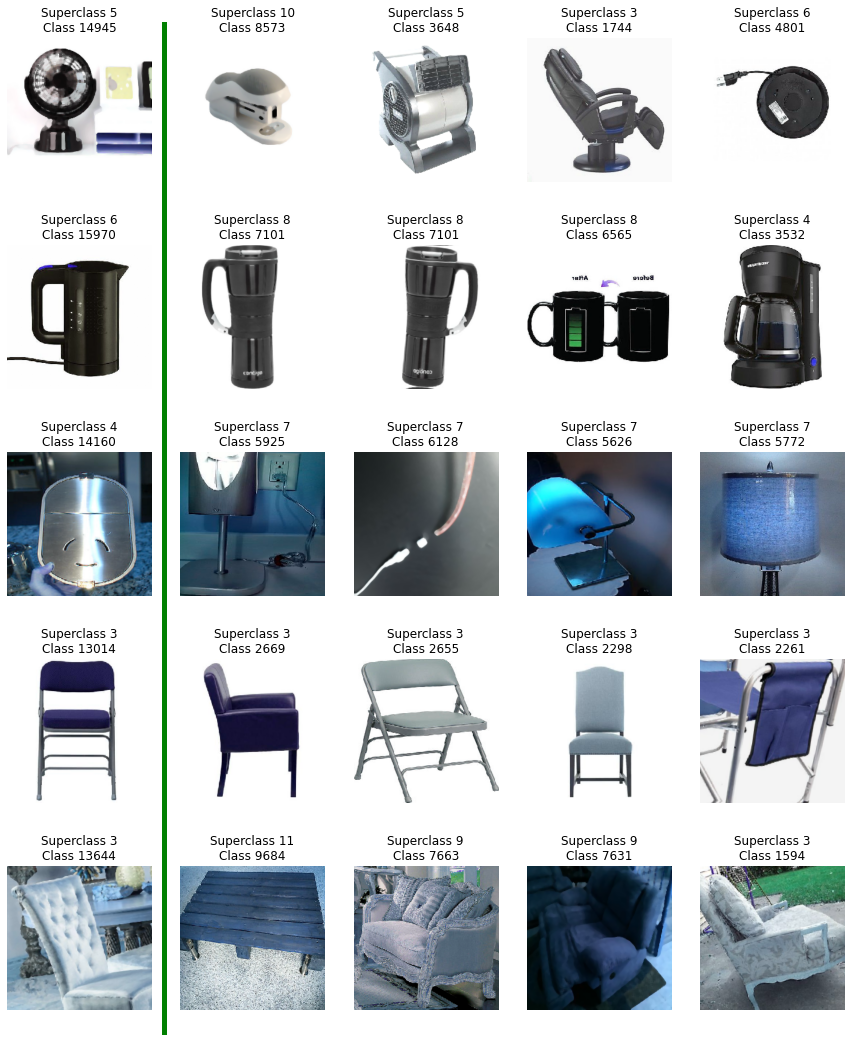

In [44]:
visualize_retrieval(resnet18_triplet_loss, layer_triplet_loss, annoy_triplet_index)

# Conclusions

All five steps of this homework have been performed. I have evaluated the baseline resnet18 model along with four differently fine-tuned models.

Vanilla Cross-Entropy and classification approach model has shown great results on the superclass retrival reaching 79% Top-5 accuracy score but it performed poorly on simple class retrieval.

The model fine-tuned on ArcFace loss showed the best results in terms of simple class retrieval reaching 11% Top-5 accuracy score but it performed worse on superclass retrieval reaching only 51%.

Based on each model, indices have been built and image retrieval has been visualized for the test dataset (which the model has not seen before).